In [76]:
# Required libraries:

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.utils import image_dataset_from_directory

# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_input_mobilenet

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data

In [53]:
# Load the train, validation, and test data:

split_data_path="/kaggle/input/flowers-split/split_folder"

train_data_dir = split_data_path+"/train/" # CHECK THIS DIRECTORY!

train_ds = image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(128,128),
    batch_size=32,
    seed=42)

val_data_dir = split_data_path+"/val/" # CHECK THIS DIRECTORY!

val_ds = image_dataset_from_directory(
    val_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(128,128),
    batch_size=32,
    seed=42)

test_data_dir = split_data_path+"/test/" # CHECK THIS DIRECTORY!

test_ds = image_dataset_from_directory(
    test_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(128,128),
    batch_size=32,
    seed=42,
    shuffle=False)

Found 12586 files belonging to 16 classes.
Found 1567 files belonging to 16 classes.
Found 1587 files belonging to 16 classes.


# CNN

In [18]:
# Create data augmentation layers:

data_augmentation = models.Sequential()

data_augmentation.add(layers.RandomFlip("horizontal"))
data_augmentation.add(layers.RandomZoom((0.1, 0.2)))
data_augmentation.add(layers.RandomTranslation(0.2, 0.3))
data_augmentation.add(layers.RandomRotation(0.1))

# Load MobileNet model from tensorflow:

mobilenet_model = MobileNet(weights="imagenet", include_top=False, input_shape=(128,128,3))

# Make sure we don't re-train the parameters:

mobilenet_model.trainable = False

# Create full model architecture suited to our task:

inputs = layers.Input(shape = (128, 128, 3))

x = data_augmentation(inputs) # We still have our data augmentation layers

x = preprocess_input_mobilenet(x) # Then a preprocessing layer specifically designed for MobileNet

x = mobilenet_model(x) # Then our transfer learning model

x = layers.Flatten()(x) # Flatten image tensors

x = layers.Dense(256, activation = "relu")(x) # Add a dense layer with dropout
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation = "relu")(x) # Add another dense layer with dropout
x = layers.Dropout(0.4)(x)

pred = layers.Dense(16, activation = "softmax")(x) # Add the prediction layer for 16-class classification

# Use the keras functional API to create our model:

final_model = models.Model(inputs = inputs, outputs = pred)

In [19]:
final_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 128, 128, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 128, 128, 3)       0         
 mbda)                                                           
                                                                 
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                           

In [20]:
# Compile the model:

final_model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

# Add early stopping:

es = EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='val_loss'
)

# Reduce learning rate when approaching minimum:

lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    min_lr=0
)

# Save best model as we go:

mcp = ModelCheckpoint(
    "mobilenet_tl_model.h5",
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True
)

# Fit the model:

history = final_model.fit(
    train_ds,
    batch_size=32,
    epochs=200,
    validation_data=val_ds,
    callbacks=[es,lr,mcp],
    verbose=1
)

Epoch 1/200
394/394 [==============================] - 13s 26ms/step - loss: 1.8556 - accuracy: 0.4611 - val_loss: 0.7875 - val_accuracy: 0.7607 - lr: 0.0010
Epoch 2/200
394/394 [==============================] - 9s 23ms/step - loss: 1.2429 - accuracy: 0.6324 - val_loss: 0.6181 - val_accuracy: 0.8092 - lr: 0.0010
Epoch 3/200
394/394 [==============================] - 10s 24ms/step - loss: 1.0617 - accuracy: 0.6819 - val_loss: 0.5552 - val_accuracy: 0.8283 - lr: 0.0010
Epoch 4/200
394/394 [==============================] - 9s 22ms/step - loss: 0.9449 - accuracy: 0.7191 - val_loss: 0.5900 - val_accuracy: 0.8251 - lr: 0.0010
Epoch 5/200
394/394 [==============================] - 9s 23ms/step - loss: 0.8753 - accuracy: 0.7422 - val_loss: 0.5449 - val_accuracy: 0.8385 - lr: 0.0010
Epoch 6/200
394/394 [==============================] - 9s 22ms/step - loss: 0.8398 - accuracy: 0.7491 - val_loss: 0.5181 - val_accuracy: 0.8513 - lr: 0.0010
Epoch 7/200
394/394 [==============================] - 9

# Plots

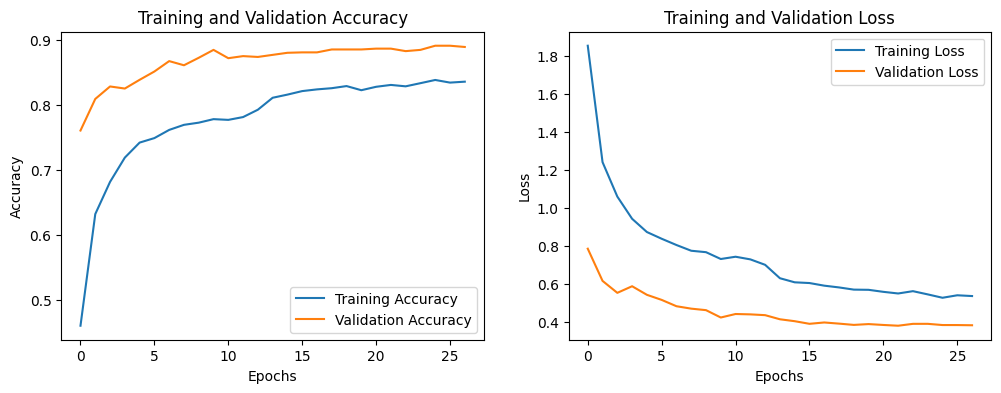

In [21]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the accuracy graph on the first subplot
ax1.plot(train_acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='best')
ax1.set_title('Training and Validation Accuracy')

# Plot the loss graph on the second subplot
ax2.plot(train_loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='best')
ax2.set_title('Training and Validation Loss')

# Display the graphs
plt.show()

# Evaluate

In [62]:
print(f"Accuracy on test set: {final_model.evaluate(test_ds,verbose=0)[1]}")

Accuracy on test set: 0.8878386616706848


# Confusion

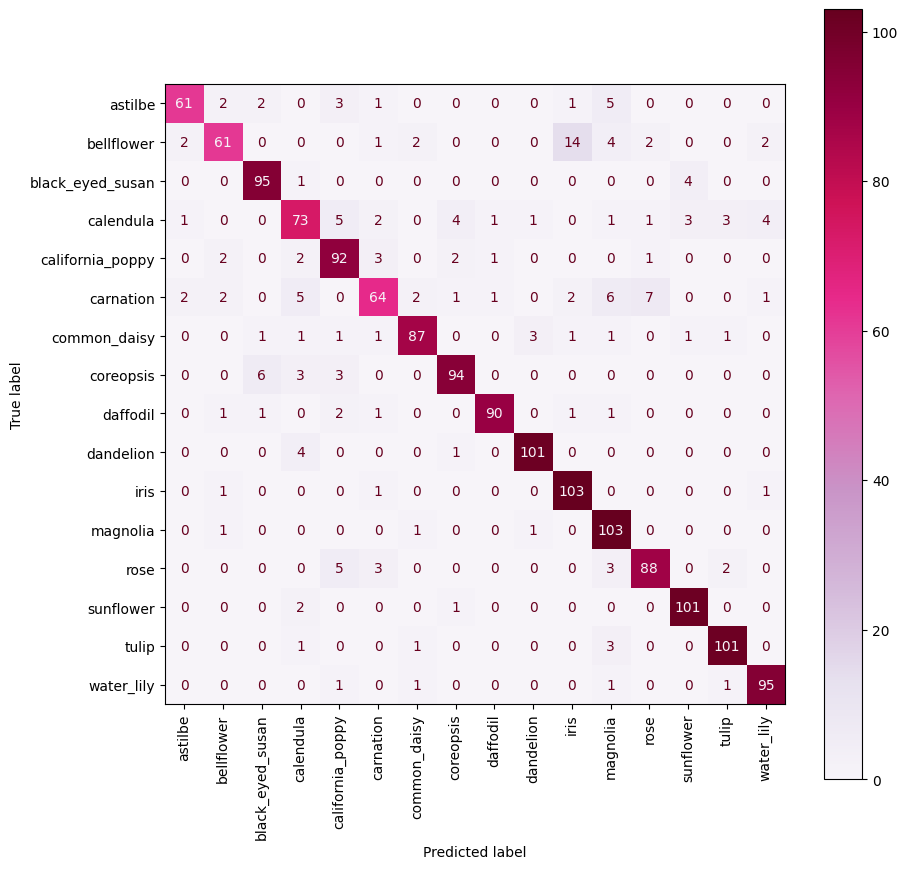

In [85]:
# Create the list of predicted labels for the test set:

y_pred_ohe = final_model.predict(test_ds,verbose=0)
y_pred = np.argmax(y_pred_ohe, axis=1)

# Create the list of true labels for the test set:

y_test_ohe = np.concatenate([y for x, y in test_ds], axis=0)
y_test = np.argmax(y_test_ohe, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap="PuRd", xticks_rotation=90);